# DAML Project-4: 
## Exotic searches with ATLAS and ML Classification

Aim: evaluate the statistical significance of a signal-like deviation in the simulated data and to determine if the ML classifier can improve the sensitivity of the search, and quantify any gains

The project consists of two parts:
1. The traditional approach where we apply some (so-called “square”) selection cuts on the kinematic variables, and then attempt two fits (for the H0 and H1 hypotheses) on the mass spectrum. We use the fit results to quantify the size of the deviation.


2. The incorporation of a ML classifier in order to improve the S/B ratio in the region of interest, to be followed by the same two-fit procedure, and the quantitative evaluation of the deviation.

In [1]:
import tensorflow
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
plt.rcParams['figure.figsize'] = (7, 7)
plt.rcParams['font.size'] = 14

In [3]:
#read in the data as csv files
data_Zj = pd.read_csv('Zjets.csv')
data_Db = pd.read_csv('Diboson.csv')
data_top = pd.read_csv('Top.csv')
data_ggH = pd.read_csv('ggH1000.csv')

In [4]:
#drop index column
data_Zj.drop(data_Zj.columns[0], axis=1, inplace=True)
data_Db.drop(data_Db.columns[0], axis=1, inplace=True)
data_top.drop(data_top.columns[0], axis=1, inplace=True)
data_ggH.drop(data_ggH.columns[0], axis=1, inplace=True)

In [5]:
#check head of data
data_Zj.head(5)

,FullEventWeight,MET,Topology,Zll_mass,Zll_pt,fatjet_C2,fatjet_D2,fatjet_E,fatjet_eta,fatjet_phi,...,lep1_eta,lep1_phi,lep1_pt,lep2_E,lep2_charge,lep2_eta,lep2_phi,lep2_pt,reco_zv_mass,truth_zv_mass
0,-0.790471,177227.420,1,95697.766,64252.690,0.097862,1.895164,425871.88,-1.329446,-0.485957,...,1.782276,-1.057460,76128.370,12476.566,1,-0.289019,1.966965,11973.011,596020.44,-1.0
1,0.789204,10660.757,1,90289.914,32506.705,0.000000,0.000000,247948.36,-0.429050,2.770810,...,-0.918399,-1.229385,40799.945,38147.754,1,0.847265,0.995251,27624.867,260357.19,-1.0
2,-0.872639,655334.400,1,92994.430,55287.625,0.059006,2.463149,630492.94,-0.543789,-2.190247,...,-1.091297,0.865696,57988.660,29768.775,1,0.440004,-1.042492,27102.590,422698.44,-1.0
3,-0.772697,41489.973,1,89607.580,63405.484,0.265080,2.081222,610611.56,1.776149,-0.214862,...,1.238367,2.127853,55424.742,69817.470,1,0.809497,-2.276664,51873.030,302718.06,-1.0
4,1.581337,41731.630,1,90199.480,47187.332,0.093765,2.321676,781746.90,-1.524169,-1.101946,...,-0.116431,1.745413,68312.220,33509.810,1,0.598434,-1.972788,28290.979,461896.25,-1.0


In [6]:
#data checks for null values
print(data_Zj.dropna(inplace = True))
print(data_Zj.isnull().values.any())
print(data_Db.dropna(inplace = True))
print(data_Db.isnull().values.any())
print(data_top.dropna(inplace = True))
print(data_top.isnull().values.any())
print(data_ggH.dropna(inplace = True))
print(data_ggH.isnull().values.any())

None
False
None
False
None
False
None
False


### Kinematic variables
1. lep1 pt transverse momentum of first reconstructed lepton (in MeV/c)
2. lep2 pt transverse momentum of second reconstructed lepton (in MeV/c)
3. fatjet pt transverse momentum of reconstructed fat-jet (in MeV/c)
4. fatjet eta η of reconstructed fat-jet
5. fatjet D2 D2 of reconstructed fat-jet
6. Zll mass invariant mass of reconstructed dilepton system (in MeV/c
7. Zll pt transverse momentum of reconstructed dilepton system (in MeV/c)
8. MET transverse missing energy in reconstructed event (in MeV)
9. reco zv mass invariant mass of reconstructed dilepton-plus-fatjet
10. isSignal boolean flag: 0 for background, 1 for signal
11. FullEventWeight event-weight to normalise the various processes

## 1. Setup 20%

In [7]:
#pick only the 11 variables defined above
bkg_Zj = data_Zj[['lep1_pt','lep2_pt','fatjet_pt','fatjet_eta','fatjet_D2','Zll_mass','Zll_pt','MET','reco_zv_mass','isSignal','FullEventWeight']]

In [8]:
bkg_Db = data_Db[['lep1_pt','lep2_pt','fatjet_pt','fatjet_eta','fatjet_D2','Zll_mass','Zll_pt','MET','reco_zv_mass','isSignal','FullEventWeight']]

In [9]:
bkg_top = data_top[['lep1_pt','lep2_pt','fatjet_pt','fatjet_eta','fatjet_D2','Zll_mass','Zll_pt','MET','reco_zv_mass','isSignal','FullEventWeight']]

In [10]:
sig_H = data_ggH[['lep1_pt','lep2_pt','fatjet_pt','fatjet_eta','fatjet_D2','Zll_mass','Zll_pt','MET','reco_zv_mass','isSignal','FullEventWeight']]

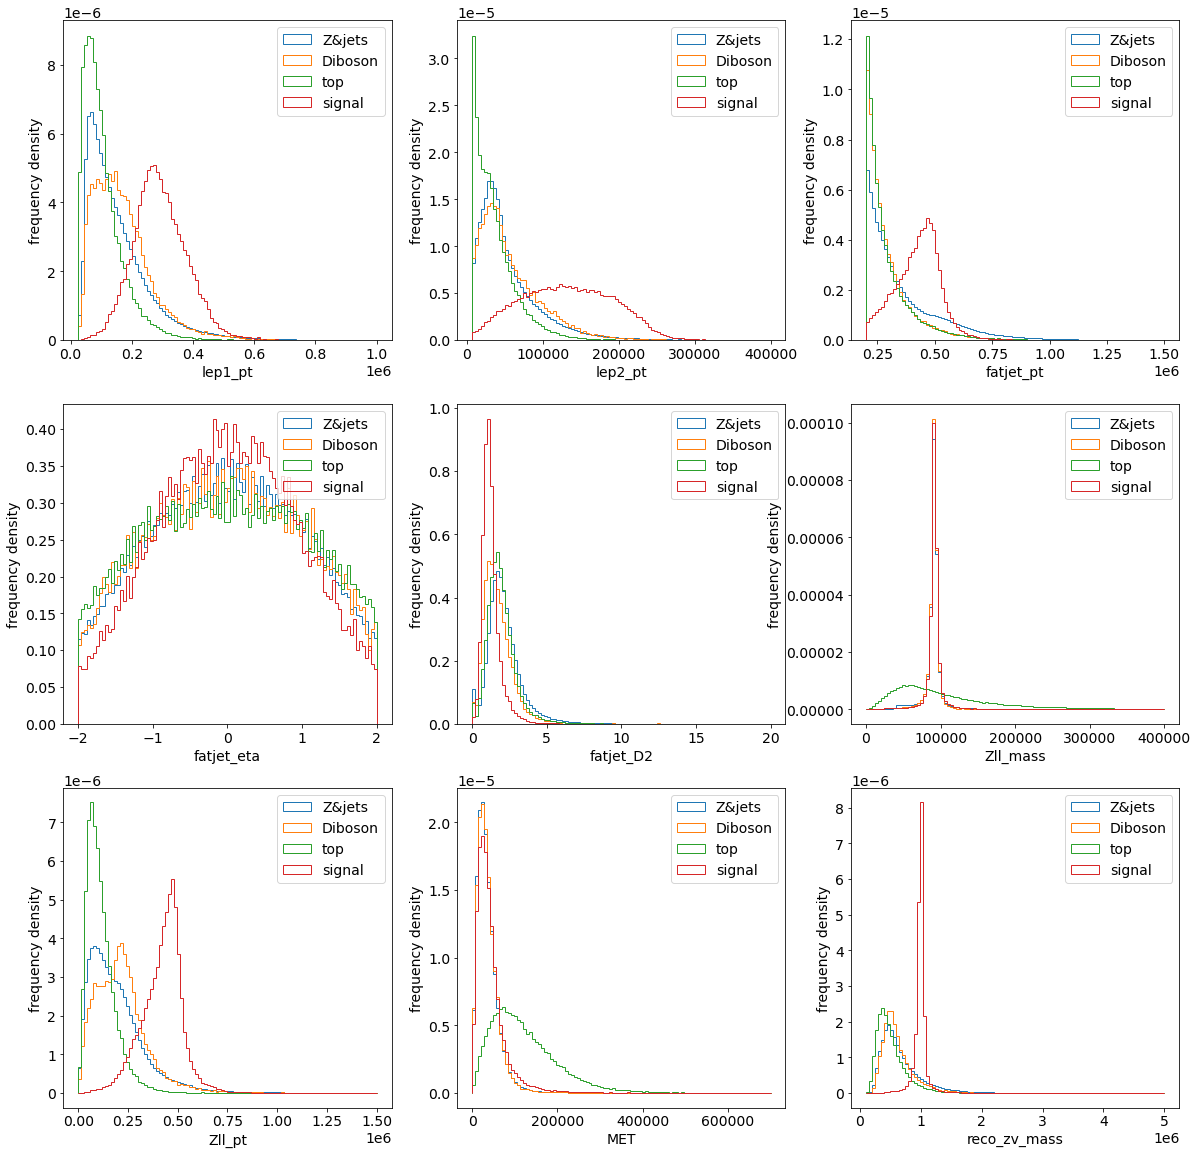

In [12]:
#create histogram for all four signals for each variable
figs, axs = plt.subplots(3, 3, figsize = (20,20))
#list of kinematic variables
column_names = ['lep1_pt','lep2_pt','fatjet_pt','fatjet_eta','fatjet_D2','Zll_mass','Zll_pt','MET','reco_zv_mass']
#list of cut offs
cut_offs = [1*1e6, 4*1e5, 1.5*1e6, 5, 20, 0.4*1e6, 1.5*1e6, 0.7*1e6, 5e6]


count = 0
for i in range(3):
    for j in range(3):
        col = column_names[count]
        cut = cut_offs[count]
        
        bkg1 = bkg_Zj.loc[bkg_Zj[col] <= cut]
        bkg2 = bkg_Db.loc[bkg_Db[col] <= cut]
        bkg3 = bkg_top.loc[bkg_top[col] <= cut]
        sig1 = sig_H.loc[sig_H[col] <= cut]
        
        bin_edge = np.linspace(np.amin(bkg1[col]),np.amax(bkg1[col]),101)
        axs[i,j].hist(bkg1[col],bins = bin_edge, histtype='step', density=True, weights=bkg1['FullEventWeight'], label='Z&jets')
        axs[i,j].hist(bkg2[col],bins = bin_edge, histtype='step', density=True, weights=bkg2['FullEventWeight'], label='Diboson')
        axs[i,j].hist(bkg3[col],bins = bin_edge, histtype='step', density=True, weights=bkg3['FullEventWeight'], label='top')
        axs[i,j].hist(sig1[col],bins = bin_edge, histtype='step', density=True, weights=sig1['FullEventWeight'], label='signal')
        axs[i,j].legend()
        axs[i,j].set_xlabel(col)
        axs[i,j].set_ylabel('frequency density')
        count += 1


This set of histograms is used as a visual aid - in order for kinematic cuts to be made by eye. The aim is to reduce background as much as possible without being too harsh (otherwise the background will be hard to model). Here it is clear that a lower cut on lep1, lep2, fat_jet_pt, Zll_pt and Zll_mass can significantly reduce background, along with upper cuts to MET and Zll_mass.

In [13]:
#copy original data to get cuts
bkg_Zj_cut = bkg_Zj.copy()
bkg_Db_cut = bkg_Db.copy()
bkg_top_cut = bkg_top.copy()
sig_H_cut = sig_H.copy()

In [14]:
#perform lower cuts on the dataframes
#dont cut for zv reco mass
#not all variables need lower cuts
column_names = ['lep1_pt','lep2_pt','fatjet_pt','Zll_mass','Zll_pt']
cut_offs = [0.1*1e6, 0.4*1e5, 0.3*1e6, 0.6*1e5, 0.3*1e6]
for i in range(5):
    col = column_names[i]
    cut = cut_offs[i]
    
    bkg_Zj_cut = bkg_Zj_cut.loc[bkg_Zj_cut[col] >= cut]
    bkg_Db_cut = bkg_Db_cut.loc[bkg_Db_cut[col] >= cut]
    bkg_top_cut = bkg_top_cut.loc[bkg_top_cut[col] >= cut]
    sig_H_cut = sig_H_cut.loc[sig_H_cut[col] >= cut]
    
    #print length to check number of entries is decreasing
    print(len(bkg_Zj_cut))
    print(len(bkg_Db_cut))
    print(len(bkg_top_cut))
    print(len(sig_H_cut))

4501426
113928
38598
49559
2839532
71884
18072
46711
1478362
31157
8806
41593
1445823
30783
8212
41133
817302
18068
1269
38745


In [15]:
#perform upper cuts on the dataframes
#dont cut for zv reco mass
column_names = ['lep1_pt','lep2_pt','fatjet_pt','fatjet_eta','fatjet_D2','Zll_mass','Zll_pt','MET']
cut_offs = [1*1e6, 4*1e5, 0.75*1e6, 5, 20, 0.4*1e6, 1.2*1e6, 1*1e5]
for i in range(8):
    col = column_names[i]
    cut = cut_offs[i]
    
    bkg_Zj_cut = bkg_Zj_cut.loc[bkg_Zj_cut[col] <= cut]
    bkg_Db_cut = bkg_Db_cut.loc[bkg_Db_cut[col] <= cut]
    bkg_top_cut = bkg_top_cut.loc[bkg_top_cut[col] <= cut]
    sig_H_cut = sig_H_cut.loc[sig_H_cut[col] <= cut]
    
    print(len(bkg_Zj_cut))
    print(len(bkg_Db_cut))
    print(len(bkg_top_cut))
    print(len(sig_H_cut))

812568
18023
1263
38739
807020
17958
1261
38729
717825
16853
961
38535
717825
16853
961
38535
714354
16802
960
38521
708578
16786
741
38506
708557
16786
741
38506
683193
16189
331
36652


In [16]:
#combine and shuffle the cut backgrounds
combined_bkg_cut = pd.concat([bkg_Zj_cut, bkg_Db_cut, bkg_top_cut], ignore_index=True)
combined_bkg_cut = sklearn.utils.shuffle(combined_bkg_cut, random_state=42, n_samples=None)

In [17]:
#combine and shuffle the original (non cut) backgrounds
combined_bkg = pd.concat([bkg_Zj, bkg_Db, bkg_top], ignore_index=True)
combined_bkg = sklearn.utils.shuffle(combined_bkg, random_state=42, n_samples=None)

In [18]:
#print percentage of background that has been cut to see if enough has been removed
(len(combined_bkg)-len(combined_bkg_cut))/len(combined_bkg)

0.8975073674823593

In [19]:
(len(sig_H)-len(sig_H_cut))/len(sig_H)

0.26715054085937656

The fractions above show the impact of the cuts on background and signal size. The kinematic cuts have removed 89.7%% of the background and only 26.7% of the signal. These were the best values I could obtain while still getting a mass spectrum with a peak at 1TeV and still have a background that can be modelled as linear (or higher order polynomials).

The fit will be performed on a subset of the mass spectrum, in order to efficiently model it. Printed below is the uncut (original) background and signal seperately, for the whole mass range. As you can see it would be difficult to model the background for the whole mass range and hard to see a peak. Therefore I cut at 0.8TeV and 1.4TeV, as the signal is at 1TeV which is shown below.

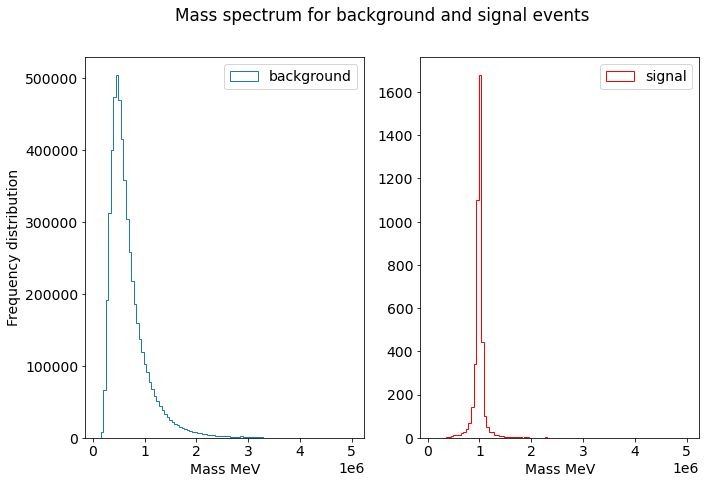

In [20]:
#plot histogram of background and signal to see where signal lies - at 1TeV

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11,7))
fig.suptitle('Mass spectrum for background and signal events')

#get n, bins and histogram for EVENTS i.e. apply the event weightings, for background
n_cut,bins_cut,_= ax1.hist(combined_bkg['reco_zv_mass'],bins = bin_edge, histtype='step', weights=combined_bkg['FullEventWeight'], label='background')
ax1.set_xlabel('Mass MeV')
ax1.legend()
ax1.set_ylabel('Frequency distribution')

#get n, bins and histogram for EVENTS i.e. apply the event weightings for signal
n,bins,_= ax2.hist(sig_H['reco_zv_mass'],bins = bin_edge, histtype='step', weights=sig_H['FullEventWeight'],color='r', label='signal')
ax2.legend()
ax2.set_xlabel('Mass MeV')

plt.show()

In [21]:
#combine cut background and signal
combined_bkg_sig_cut = pd.concat([combined_bkg_cut, sig_H_cut], ignore_index=True)

#combine background and signal
combined_bkg_sig = pd.concat([combined_bkg, sig_H], ignore_index=True)

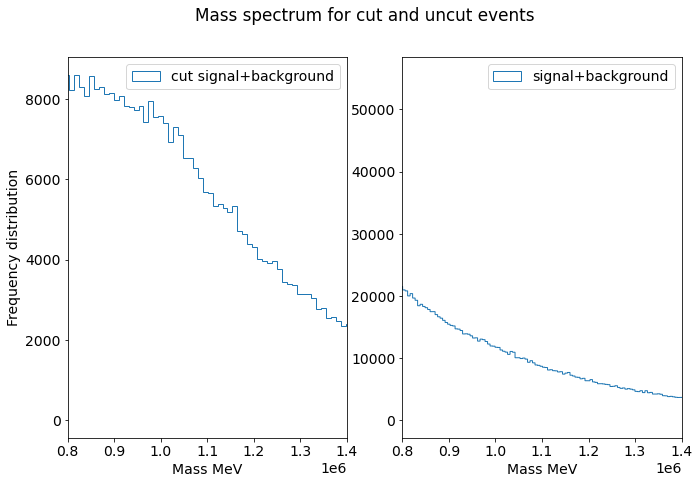

In [182]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11,7))
fig.suptitle('Mass spectrum for cut and uncut events')

#get n, bins and histogram for EVENTS i.e. apply the event weightings, after the cuts are applied
n_cut,bins_cut,_= ax1.hist(combined_bkg_sig_cut['reco_zv_mass'],weights=combined_bkg_sig_cut['FullEventWeight'],histtype='step',bins=500,label='cut signal+background')
ax1.legend()
ax1.set_xlabel('Mass MeV')
ax1.set_ylabel('Frequency distribution')
#zoom into 0.8 - 1.4 TeV region to see signal at 1TeV
ax1.set_xlim([0.8*1e6,1.4*1e6])

#get n, bins and histogram for EVENTS i.e. apply the event weightings, before the cuts are applied
n,bins,_= ax2.hist(combined_bkg_sig['reco_zv_mass'],weights=combined_bkg_sig['FullEventWeight'],histtype='step',bins=10000,label='signal+background')
ax2.legend()
ax2.set_xlabel('Mass MeV')
ax2.set_xlim([0.8*1e6,1.4*1e6])

plt.show()

In [189]:
len(sig_H), len(combined_bkg)

(50013, 6826959)

In [190]:
len(sig_H_cut), len(combined_bkg_cut)

(36652, 699713)

In [192]:
#signal to noise ratio for cut data
len(sig_H_cut)/len(combined_bkg_cut)

0.052381476405326186

In [193]:
#signal to noise ratio for original data
len(sig_H)/len(combined_bkg)

0.007325809339121562

This image shows the cut signal+background spectrum and the uncut signal+background spectrum for the 0.8-1.4TeV mass range. Whilst it is subtle, it can be seen that the cuts give a visible small signal bump at 1TeV. In order to see it more clearly, I get the mid points and plot it as a scatter plot as opposed to the histogram. By cutting kinematic variables at energy values that are specific to the different backgrounds, it allows for the signal to be seen. There is a lot less signal data and the weightings are a lot smaller so much of it needs to be cut to allow for signal to be seen. The signal to noise ratio for uncut is 0.0073 whereas for cut it is 0.052.

In [183]:
bin_center_cut = bins_cut[:-1] + np.diff(bins_cut) / 2
n_cut = n_cut[np.where((bin_center_cut<1.4e6) & (bin_center_cut>0.8e6))]
bin_center_cut = bin_center_cut[bin_center_cut<1.4e6]
bin_center_cut = bin_center_cut[bin_center_cut>0.8e6]

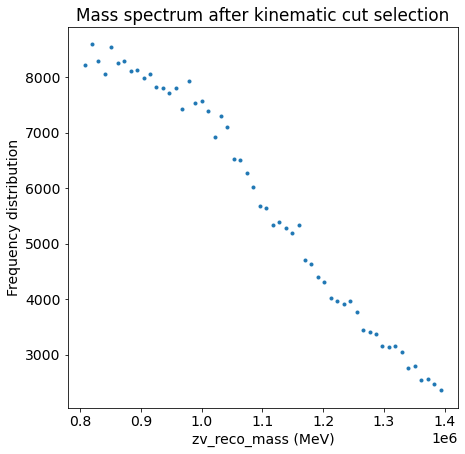

In [194]:
plt.plot(bin_center_cut,n_cut,'.')
plt.xlabel('zv_reco_mass (MeV)')
plt.title('Mass spectrum after kinematic cut selection')
plt.ylabel('Frequency distribution')
plt.show()

In [185]:
#sum of events before cuts
sum_precut = np.sum(n)
#sum of events before cuts
sum_cut = np.sum(n_cut)

In [186]:
sum_precut

5406873.732577496

In [187]:
sum_cut

320112.5144893734

The number of **events** (i.e. the entries multiplied by their weightings, given by the histogram, before cuttings is $5.4 \times 10^6$, and after cutting it is $3.2 \times 10^5$.

---

To compare the weights I take the mean, since there is much more background data than signal data, so summing them would not give a tangible result. The mean of weights for background is 0.8 whereas for signal it is ~10x smaller at 0.08. This is what makes the signal much less visible, and it means that when the data is fed to the neural net **without** weightings, that the signal will be much more visible and the NN can do a much better job at predicting signal and background. This can also be visualised by printing out the data without the weightings:

In [30]:
#mean event weight for background
np.mean(combined_bkg['FullEventWeight'])

0.7913733730232553

In [31]:
#mean event weight for signal
np.mean(sig_H['FullEventWeight'])

0.08398138995904965

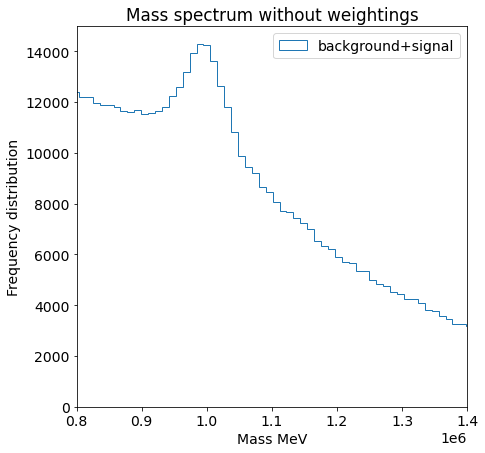

In [197]:
#plot cut data without weightings to see significance of weights
plt.hist(combined_bkg_sig_cut['reco_zv_mass'],bins =500, histtype='step',label='background+signal')
plt.xlim([0.8e6,1.4e6])
plt.title('Mass spectrum without weightings')
plt.legend()
plt.xlabel('Mass MeV')
plt.ylabel('Frequency distribution')
plt.show()

## 2. Fitting and hypothesis-testing [30%]


Model the `reco_zv_mass` mass spectrum for the signal and background processes
separately after the chosen selection cuts with appropriate fitting functions. You
may want to try using e.g. a single Gaussian for the signal and a polynomial for
the background. These suggestions may not work if you have significantly altered
(“sculpted”) the mass spectrum in your effort to make the signal more visible. You
probably want to perform the fit on a subrange of the mass spectrum (see Fig. 1).

In [33]:
from scipy.optimize import curve_fit
from scipy.optimize import minimize

### 2.1. Fitting weighted signal data seperately using a standard minimizer to get guesses for $\chi^2$ minimiser.

In [34]:
#get n and bins for SIGNAL ONLY
n_cut_sig,bins_cut_sig=np.histogram(sig_H_cut['reco_zv_mass'],weights=sig_H_cut['FullEventWeight'],bins=500)

In [35]:
#get bin midpoints and heights where the mass is in the subrange (0.8TeV-1.4TeV)
bin_center_sig = bins_cut_sig[:-1] + np.diff(bins_cut_sig) / 2
n_sig = n_cut_sig[np.where((bin_center_sig<1.4e6) & (bin_center_sig>0.8e6))]
bin_center_sig = bin_center_sig[bin_center_sig<1.4e6]
bin_center_sig = bin_center_sig[bin_center_sig>0.8e6]

In [36]:
#get weighted signal statistics
from statsmodels.stats.weightstats import DescrStatsW

#get mean and standard deviation of signal data 
weighted_sig = DescrStatsW(sig_H_cut['reco_zv_mass'], weights=sig_H_cut['FullEventWeight'], ddof=0)
sig_mean = weighted_sig.mean
sig_std = weighted_sig.std

In [198]:
#curve fit to a gaussian for the signal data
def gauss_fit(data,A,mean,sigma):
    """Function that returns a Gaussian, normalisation is allowed for in the constant, A."""
    return A*np.exp(-0.5*(data-mean)**2/(sigma**2))

A = 175
popt_sig,pcov_sig = curve_fit(gauss_fit,bin_center_sig,n_sig,p0=[A,sig_mean,sig_std])

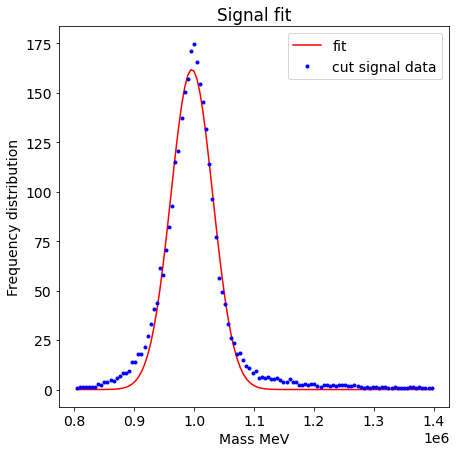

In [200]:
#plot signal fit against signal data
plt.plot(bin_center_sig,gauss_fit(bin_center_sig,*popt_sig),label='fit',color='r')
plt.plot(bin_center_sig,n_sig,'.',label='cut signal data',color='b')
plt.legend()
plt.xlabel('Mass MeV')
plt.ylabel('Frequency distribution')
plt.title('Signal fit')
plt.show()

This seperate fit tells us the width and mean of the gaussian. The reason the normalization will be different is because for the signal only data, there is a lot less, and when I fit to the signal+background data the normalization will be very different. For this reason normalization is left as a free paramater. In this case, I give a guess as the height of the bell curve.

### 2.2. Fitting weighted background data seperately using a standard minimizer to get guesses for $\chi^2$ minimiser.

In [202]:
#get n and bins for BACKGROUND ONLY

n_cut_bkg,bins_cut_bkg=np.histogram(combined_bkg_cut['reco_zv_mass'],weights=combined_bkg_cut['FullEventWeight'],bins=500)

In [203]:
#get bin midpoints and heights where the mass is in the subrange (0.8TeV-1.4TeV)

bin_center_bkg = bins_cut_bkg[:-1] + np.diff(bins_cut_bkg) / 2
n_bkg = n_cut_bkg[np.where((bin_center_bkg<1.4e6) & (bin_center_bkg>0.8e6))]
bin_center_bkg = bin_center_bkg[bin_center_bkg<1.4e6]
bin_center_bkg = bin_center_bkg[bin_center_bkg>0.8e6]

In [204]:
def linear_fit(x, a, b, N):
    """Function that returns a straight line, normalisation allowed for in constant, N"""
    y = a*x + b 
    return y*N

In [205]:
#get linear parameters from curve fitting background to a straight line
popt_lin, cov_lin = curve_fit(linear_fit, bin_center_bkg, n_bkg)

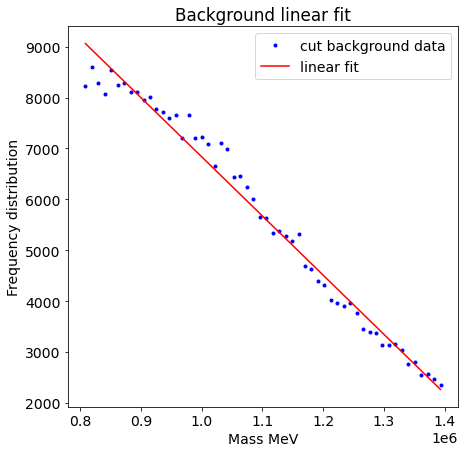

In [206]:
#plot background fit against background data

plt.plot(bin_center_bkg,n_bkg,'.',label='cut background data',color='b')
plt.plot(bin_center_bkg,linear_fit(bin_center_bkg,*popt_lin),'r',label='linear fit')
plt.legend()
plt.xlabel('Mass MeV')
plt.ylabel('Frequency distribution')
plt.title('Background linear fit')
plt.show()

In [44]:
### Trying a 3rd order polynomial
def poly_fit3(x, a, b, c, N):
    """function that returns a 3rd degree polynomial"""
    y = a*x**3 + b*x**2 + c*x + 1
    #normalization allowed for by constant N
    return y*N

Having another parameter 'd' as the intercept meant that the solver was being passed too many variables. As an equivalent, I set the intercept as 1, and then when multiplied by normalization factor N, this is dealt with and will be normalized.

In [45]:
#get parameters from curve fitting background to a cubic function
popt_3d, cov_3d = curve_fit(poly_fit3, bin_center_bkg, n_bkg)

In [46]:
#3rd degree parameters
popt_3d

array([-1.26493903e-02,  4.65887937e+04, -4.21626363e+10, -8.47078332e-13])

Text(0, 0.5, 'Frequency distribution')

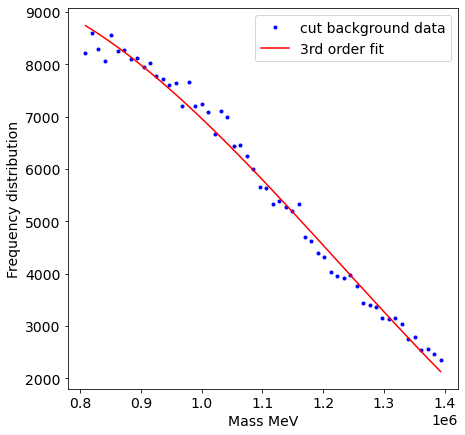

In [47]:
#plot background data and 3rd order fit
plt.plot(bin_center_bkg,n_bkg,'.',label='cut background data',color='b')
plt.plot(bin_center_bkg,poly_fit3(bin_center_bkg,*popt_3d),'r',label='3rd order fit')
plt.legend()
plt.xlabel('Mass MeV')
plt.ylabel('Frequency distribution')

In [48]:
### Trying a 4th order polynomial
def poly_fit4(x, a, b, c, d, N):
    """function that returns a 3rd degree polynomial"""
    y = a*x**4 + b*x**3 + c*x**2 + d*x + 1
    return y*N

In [49]:
#get 4th order parameters from curve fit
popt_4d, cov_4d = curve_fit(poly_fit4, bin_center_bkg, n_bkg)

C:\Users\betc\anaconda3\envs\daml\lib\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [50]:
popt_4d

array([ 6.37294897e-05, -1.87553961e+02,  1.40540816e+08,  1.00000000e+00,
        4.24623000e-16])

Text(0, 0.5, 'Frequency distribution')

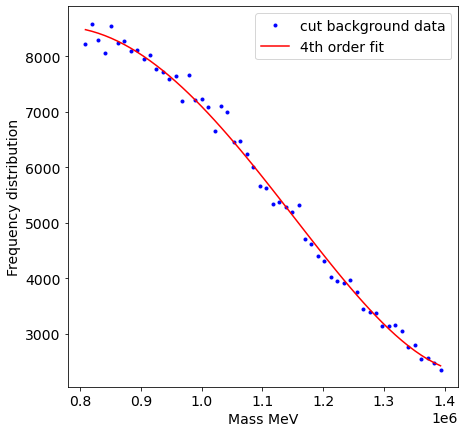

In [51]:
#plot background data to 4th order fit
plt.plot(bin_center_bkg,n_bkg,'.',label='cut background data',color='b')
plt.plot(bin_center_bkg,poly_fit4(bin_center_bkg,*popt_4d),'r',label='4th order fit')
plt.legend()
plt.xlabel('Mass MeV')
plt.ylabel('Frequency distribution')

As we can see, this 4th order polynomial is the best fit for the background data. And so I fit again but for the full data (100 bins), signal+background, that will be used in the $\chi^2$ minimization, in order to provide guesses to the solver. If I don't provide guesses, the solver fails as there are a lot of free parameters in a fourth order fit. Fitting the background to the full data means that the normalization will be correct as the bins will be at the correct height. These variables can then be passed to the composite function solver in order to make it work. This is equivalent to the H0 hypothesis - fitting a  background only fit to the signal+background data.

In [52]:
### Trying a 4th order polynomial
def poly_fit4(x, a, b, c, d):
    y = a*x**4 + b*x**3 + c*x**2 + d*x
    return y

Here, the normalization is included in the constants. This is because the solver failed to get the optimal parameters when N was included, as different combinations of a,b,c,d and N could give the same results.

In [207]:
##get n and bins for BACKGROUND + SIGNAL

data = combined_bkg_sig_cut.copy()
data = data.loc[(data['reco_zv_mass'] >= 0.8e6) & (data['reco_zv_mass'] <= 1.4e6)]
n,hist_bins = np.histogram(data['reco_zv_mass'],weights=data['FullEventWeight'], bins=100)
n2,hist_bins2 = np.histogram(data['reco_zv_mass'],weights=data['FullEventWeight']**2, bins=100)
bin_centers = hist_bins[:-1] + np.diff(hist_bins)/2

In [208]:
#fit the 4d background to signal plus background in order to get guesses to pass to solver for the composite function
popt_4d, cov_4d = curve_fit(poly_fit4, bin_centers, n)

In [209]:
popt_4d

array([ 2.56707649e-20, -8.01801454e-14,  7.27829898e-08, -1.41610634e-02])

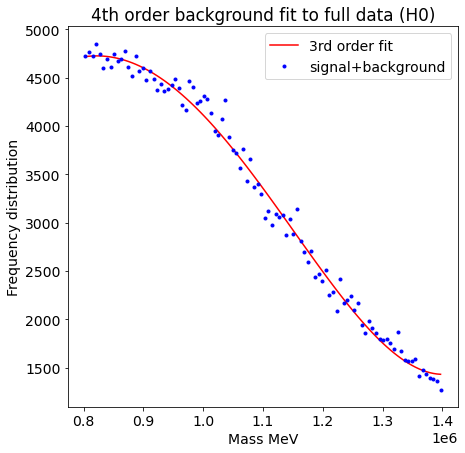

In [212]:
#plot 4th order background only fit to signal plus background data
plt.plot(bin_centers,poly_fit4(bin_centers,*popt_4d),'r',label='3rd order fit')
plt.plot(bin_centers,n,'b.',label='signal+background')
plt.legend()
plt.title('4th order background fit to full data (H0)')
plt.xlabel('Mass MeV')
plt.ylabel('Frequency distribution')
plt.show()

### 2.3. Fitting weighted signal+background data using a standard minimizer to get guesses for $\chi^2$ minimiser.

In [58]:
#fraction is sum of signal over sum of background in that range
F = np.sum(n_sig)/np.sum(n_bkg)
F

0.009554680157276589

Keep the parameters of the signal model (e.g. mean and sigma for a Gaussian) fixed to the values determined
    by the fit on the signal-only spectrum, but with the overall normalisation left as a
    free parameter. Assume that the background shape is unknown (i.e. you can use
    your function of choice, but all parameters should be free to float in the fit)

In [59]:
def composite_lin(data, a, b, F, k):
    
    """A function which returns a composite function of a gaussian signal and a first order polynomial background"""
    
    #fixing mu and sigma as given by gaussian fit
    mean = 9.96182479e+05
    sigma = 4.93363203e+04
    
    #background given as 1st degree (linear) polynomial
    BKG = (a + b*data)
    
    #signal given as gaussian with mean 'gauss_mu' and standard deviation 'sigma'
    GAUSS = np.exp(-0.5*(data-mean)**2/sigma**2) 
    
    #returns composite function (1-fraction of background) + (fraction) of signal
    return ((1-F)*BKG + F*GAUSS)*k

In [60]:
#get parameters for the composite linear fit
popt_comp_lin, cov_comp_lin = curve_fit(composite_lin, bin_centers, n)

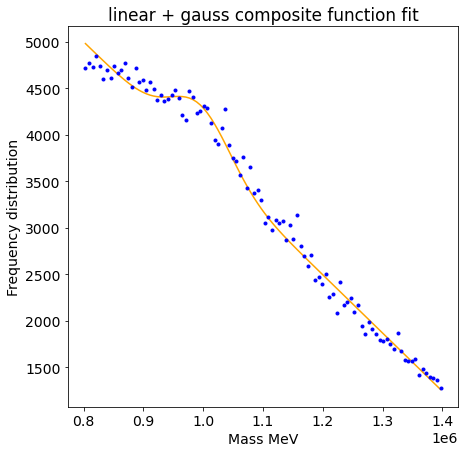

In [213]:
plt.plot(bin_centers,composite_lin(bin_centers,*popt_comp_lin),'orange')
plt.plot(bin_centers,n,'b.')
plt.title('linear + gauss composite function fit')
plt.xlabel('Mass MeV')
plt.ylabel('Frequency distribution')
plt.show()

In [215]:
def composite_3d(data, a, b, c, h, F):
    
    """A function which returns a composite function of a gaussian signal and a third order polynomial background"""
    
    #normalisation allowed by constants
    
    #fixing mu and sigma as given by gaussian fit
    mean = 9.96182479e+05
    sigma = 4.93363203e+04
    
    #background given as a third degree polynomial
    BKG = a*data**3 + b*data**2 + c*data
    
    #signal given as normalised gaussian with mean 'gauss_mu' and standard deviation 'sigma'
    GAUSS = h*np.exp(-0.5*(data-mean)**2/sigma**2)
    
    #returns composite function (1-fraction of background) + (fraction) of signal
    return ((1-F)*BKG + F*GAUSS)

In [216]:
#guesses come from background curve fit values
a,b,c = popt_3d[:-1]
#h is height
#F is fraction (fraction will have a weird meaning here as it will include normalisation)

In [217]:
#get params for 3d polynomial + gaussian composite fit
popt_comp3d, cov_comp3d = curve_fit(composite_3d, bin_centers, n,p0=[a,b,c,100,0.001])

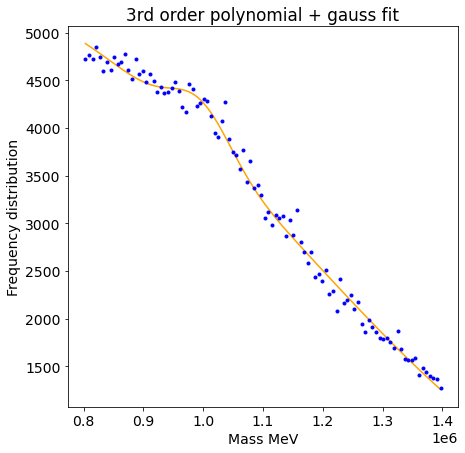

In [218]:
plt.plot(bin_centers,composite_3d(bin_centers,*popt_comp3d),'orange')
plt.plot(bin_centers,n,'b.')
plt.title('3rd order polynomial + gauss fit')
plt.xlabel('Mass MeV')
plt.ylabel('Frequency distribution')
plt.show()

In [66]:
def composite_4d(data, a, b, c, d, h, F):
    
    """A function which returns a composite function of a gaussian signal and a 4th order polynomial background"""
    
    #normalisation allowed by constants
    
    #fixing mu and sigma as given by gaussian fit
    mean = 9.96182479e+05
    sigma = 4.93363203e+04
    
    #background given as a 4th degree polynomial
    BKG = a*data**4 + b*data**3 + c*data**2 + d*data
    
    #signal given as gaussian with mean 'gauss_mu' and standard deviation 'sigma' and height h
    GAUSS = h*np.exp(-0.5*(data-mean)**2/sigma**2)
    
    #returns composite function (1-fraction of background) + (fraction) of signal
    return ((1-F)*BKG + F*GAUSS)

In [67]:
#p0 estimates come from background-only fit
a,b,c,d = popt_4d

In [68]:
#get composite parameters for 4d + gaussian fit
popt_comp4d, cov_comp4d = curve_fit(composite_4d, bin_centers,n,p0=[*popt_4d,100,0.001])

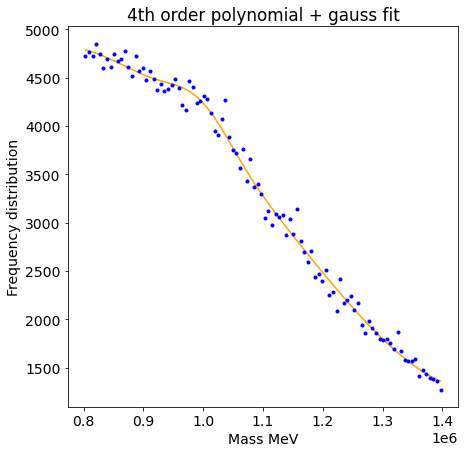

In [219]:
plt.plot(bin_centers,composite_4d(bin_centers,*popt_comp4d),'orange')
plt.plot(bin_centers,n,'b.')
plt.title('4th order polynomial + gauss fit')
plt.xlabel('Mass MeV')
plt.ylabel('Frequency distribution')
plt.show()

Again for the 3d and 4d case the normalization is included in the constants as leaving it as an extra free parameter at the end caused the solver to fail.

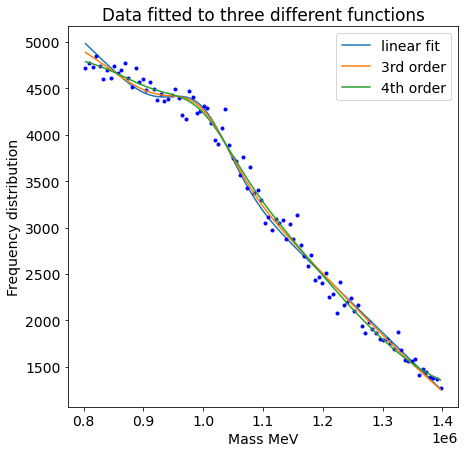

In [220]:
#plot data against the 3 different composite fits
plt.plot(bin_centers,composite_lin(bin_centers,*popt_comp_lin),label='linear fit')
plt.plot(bin_centers,n,'b.')
plt.plot(bin_centers,composite_3d(bin_centers,*popt_comp3d),label='3rd order')
plt.plot(bin_centers,composite_4d(bin_centers,*popt_comp4d),label='4th order')
plt.legend()
plt.title('Data fitted to three different functions')
plt.xlabel('Mass MeV')
plt.ylabel('Frequency distribution')
plt.show()

Here we can see that the fourth order background with guassian signal is the best fit, particularly in the lower region between 0.8 and 0.9 TeV it is in the center of the points as opposed to far above them like third and first order polynomials. This should significantly reduce the chi squaered value as these differences between data and the fit will blow up (some differ by around 250).

---

## $\chi^2$ minimisation - fitting for H0 and H1 hypotheses

 If the events are assigned weights, then we find that sum of the weights plays the role of n and the sum of the weights squared can be used to estimate the variance. The variance is given by n2 given by the histogram - i.e. the entries when weightings are squared.

In [71]:
##get n and bins for BACKGROUND + SIGNAL
data = combined_bkg_sig_cut.copy()
data = data.loc[(data['reco_zv_mass'] >= 0.8e6) & (data['reco_zv_mass'] <= 1.4e6)]
n,hist_bins = np.histogram(data['reco_zv_mass'],weights=data['FullEventWeight'], bins=100)

##get n**2 and bins for BACKGROUND + SIGNAL when the weightings are squared
n2,hist_bins2 = np.histogram(data['reco_zv_mass'],weights=data['FullEventWeight']**2, bins=100)
bin_centers = hist_bins[:-1] + np.diff(hist_bins)/2

### H0 hypothesis - background only

In [72]:
#fitting previously obtained background-only-fit to background+signal data

In [73]:
#linear fit
popt1, cov1 = curve_fit(linear_fit, bin_centers, n)

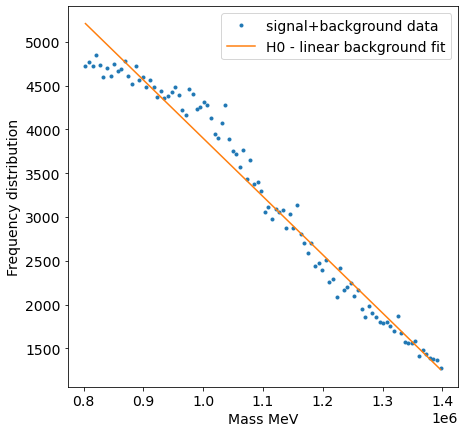

In [221]:
#plot the linear fit against signal and background data
plt.plot(bin_centers, n,'.',label='signal+background data')
y = linear_fit(bin_centers, *popt1)
plt.plot(bin_centers,y,label='H0 - linear background fit')
plt.legend()
plt.xlabel('Mass MeV')
plt.ylabel('Frequency distribution')
plt.show()


In [222]:
#get chi squared value for the H0 (linear background) hypothesis
def H0_chi2(params):
    a, b, N = params
    y = linear_fit(bin_centers, a, b, N)
    chi2 = np.sum(((n-y)**2)/n2)
    return chi2

In [223]:
H0_chi2(popt1)

410.9710158924874

The linear fit gives a chi squared value of 410. The ideal chi squared will be equal to the number of bins, as each $(data-fit)^2/variance$ should give a value of 1 ideally, which is then summed over each bin. 410 however is a poor fit, we can see that this occurs in the low energy range of 0.8 to 0.9 where the line is ~500 higher than the data points, and of course where there is a bump in the signal and the data points again are far off the line.

### H1 hypothesis

In [77]:
#get parameters for composite linear background fit
popt2, cov2 = curve_fit(composite_lin, bin_centers, n)

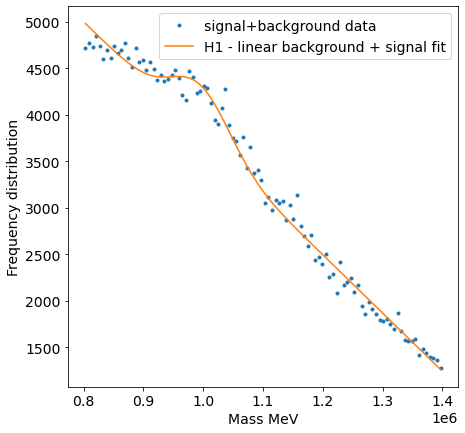

In [224]:
#plot composite fit for H1 hypothesis
plt.plot(bin_centers, n,'.',label='signal+background data')
y = composite_lin(bin_centers, *popt2)
plt.plot(bin_centers,y,label='H1 - linear background + signal fit')
plt.legend()
plt.xlabel('Mass MeV')
plt.ylabel('Frequency distribution')
plt.show()

In [79]:
#get chi squared value for H1 hypothesis
def H1_chi2(params):
    a, b, F, k = params
    y = composite_lin(bin_centers, a, b, F, k)
    chi2 = np.sum(((n-y)**2)/n2)
    return chi2

In [80]:
H1_chi2(popt2)

161.12581775765256

The H1 chi squared for the linear background plus gaussian signal fit is 160. This is relatively good however the optimal value would be 100, so it is still not the perfect fit. The p value will be extremely small, as the background fit has a high chi squared, and so the difference between the chi squareds is quite large ~250. This means that the probability of the signal occuring due to a random flucuation in the background is extremely unlikely, as the p value is essentially zero.

### Minimize the chi squared

In [81]:
h0 = minimize(H0_chi2,x0=[*popt1], method="powell")
h0

   direc: array([[-7.30765170e-06,  7.40763581e-01,  4.76600116e-04],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-2.21468510e-06, -2.37308165e+00,  1.56732436e-03]])
     fun: 406.44304363669204
 message: 'Optimization terminated successfully.'
    nfev: 137
     nit: 4
  status: 0
 success: True
       x: array([-7.94988053e-03,  1.25623527e+04,  8.44738588e-01])

In [82]:
h1 = minimize(H1_chi2,x0=[*popt2], method="powell")
h1

   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [-1.03069864e+02, -2.81770955e-05, -2.40974753e-07,
        -1.29606459e-02]])
     fun: 160.86855046224935
 message: 'Optimization terminated successfully.'
    nfev: 86
     nit: 2
  status: 0
 success: True
       x: array([ 1.77353606e+05, -1.11085881e-01,  9.99895865e-01,  5.43403478e+02])

The chi squared values are minimized slightly by `scipy.optimize.minimize`, changing from 161.12 to 160.8, and 410.9 to 406.4.

In [83]:
H1_params = h1.x
H1_params

array([ 1.77353606e+05, -1.11085881e-01,  9.99895865e-01,  5.43403478e+02])

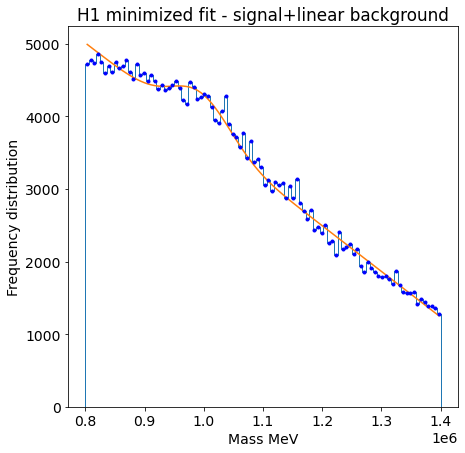

In [225]:
#get minimized fit
n,hist_bins,_ = plt.hist(data['reco_zv_mass'],histtype='step',weights=data['FullEventWeight'], bins=100)
y = composite_lin(bin_centers,  *H1_params)
plt.plot(bin_centers,y)
plt.plot(bin_centers,n,'b.')

plt.title('H1 minimized fit - signal+linear background')
plt.xlabel('Mass MeV')
plt.ylabel('Frequency distribution')
plt.show()

### Get p value and Z value from Wilk's theorem

In [85]:
from scipy.stats import chi2
from scipy.special import erfinv

In [86]:
#difference between the chi squared values for H0 and H1 hypotheses
D = h0.fun - h1.fun
#degrees of freedom (extra degree of freedom is the signal fraction in H1)
dof = 1
#get the p value difference
p_val_diff = chi2.sf(D,dof)
#get the Z score
Z = erfinv (1 - p_val_diff) * np.sqrt (2)

In [87]:
p_val_diff

2.39482597896185e-55

In [88]:
 h0.fun, h1.fun

(406.44304363669204, 160.86855046224935)

The fit for linear background is so bad for this cut data set that the p value is infinitessimal as the difference in the chi2 are so large, due to there being a massive chi2 (406) for the h0 hypothesis for background.
This shows the data clearly ca'nt be described by a fluke in background. We can see this by eye without the need for Wilk's theorem, as there is clearly a peak of data above the linear background. Because this fit for background is so poor I then experimented with other fits on the background as have been shown above. To get a more tangible p value, I use the fourth order model which looked like the best fit in the previous section.

### Fitting to 4th order polynomials 

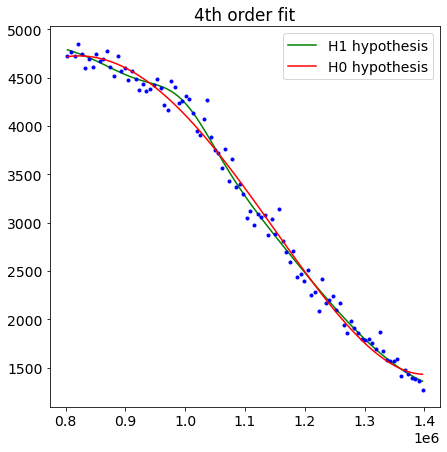

In [89]:
#plot background only (H0) and background+signal (H1) fits, for the background+signal data
plt.plot(bin_centers,composite_4d(bin_centers,*popt_comp4d),'g',label='H1 hypothesis')
plt.plot(bin_centers,n,'b.')
plt.plot(bin_centers,poly_fit4(bin_centers,*popt_4d),'r',label='H0 hypothesis')
plt.legend()
plt.title('4th order fit')
plt.show()

In [90]:
#get y values for H1 and H0 hypothesis
y1 = composite_4d(bin_centers,*popt_comp4d)
y0 = poly_fit4(bin_centers,*popt_4d)

In [226]:
#get chi squared for H1
def H1_chi2(params):
    a, b, c, h, k, F = params
    y = composite_4d(bin_centers,*params)
    chi2 = np.sum(((n-y)**2)/n2)
    return chi2

In [227]:
#get chi squared for H0
def H0_chi2(params):
    a, b, c, d = params
    y = poly_fit4(bin_centers,*params)
    chi2 = np.sum(((n-y)**2)/n2)
    return chi2

In [228]:
H1_chi2(popt_comp4d) #on the order of no bins = 100, much better fit

115.64653410520528

In [229]:
H0_chi2(popt_4d) #on the order of no bins = 100 background here is much better fit so p value difference is greater

158.76137123421466

In [95]:
#minimize chi squared functions
h0_poly = minimize(H0_chi2,x0=[*popt_4d], method="Powell")
h1_poly = minimize(H1_chi2,x0=[*popt_comp4d], method="Powell")

In [96]:
h0_poly.fun, h1_poly.fun

(158.69719594672094, 115.58095337066908)

In [97]:
#difference between the chi squared values for H0 and H1 hypotheses
D = h0_poly.fun - h1_poly.fun
#degrees of freedom (extra degree of freedom is the signal fraction in H1)
dof = 1
#get the p value difference
p_val_diff = chi2.sf(D,dof)


In [98]:
p_val_diff

5.158224684734749e-11

Here, the h1 and h0 values are much better. A particular improvement is seen in the H0 hypothesis as the background is fit much better. However, in the H0 fit, it is still easy to see by eye a deviation due to the signal, and for this reason the chi2 for the H1 hypothesis is much closer to the number of bins (115, no. bins = 100) which makes it a good fit. The difference in H1 and H0 values are still quite large so a p value on the order of $10^{-11}$ is given. This tells us that the signal is infact from the hypothetical heavy Higgs boson, and not from a random fluxtuation in background from Z bosons, jets, or top quarks. Since the chi squared fits take into account the weight of the samples, the p value is essentially 0 as a signal is quite apparent.

### Get weighted sums in bins 

I didn't end up using this code as I found you can get sum of weights squared, i.e. $\sum_j (w^{(i)}_j)^2$, from np.histogram by just passing it the weights squared. However I've left it in as I thought it was neat code that might be useful else where.

In [99]:
binned_edges = np.histogram_bin_edges(data['reco_zv_mass'], bins=100, weights=data['FullEventWeight'])
#list of bin numbers as long as entries - which entries are in which bin
bins = np.digitize(data['reco_zv_mass'], binned_edges)
data = data.reset_index()

summed_w_2 = []
for i in range(1,101):
    #what data points are in the first bin etc.. looping through all 100 bins
    x = np.where(bins==i)[0].tolist()
    y = data.loc[x]
    w_sum_2 = np.sum(y['FullEventWeight']**2)
    summed_w_2.append(w_sum_2)
    
summed_w = []
for i in range(1,101):
    x = np.where(bins==i)[0].tolist()
    y = data.loc[x]
    w_sum = np.sum(y['FullEventWeight'])
    summed_w.append(w_sum)

## 3. Employing a NN classifier [40%]

In [100]:
from sklearn import datasets, tree, metrics, model_selection, ensemble
from six import StringIO
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D
import itertools
import seaborn as sns

In [101]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

#### LOOKING AT NN PERFORMANCE FOR CUT DATA

In [102]:
#for cut data
#get number of samples same length as signal - 50%50% admixture
bkg_samples = sklearn.utils.shuffle(combined_bkg_cut, random_state=42, n_samples=len(sig_H_cut))
training1 = pd.concat([sig_H_cut, bkg_samples], ignore_index=True)

In [103]:
training1 = sklearn.utils.shuffle(training1, random_state=42)
training1.reset_index(drop=True);
target = training1['isSignal']

training_dropped1 = training1.copy()
#get rid of columns that we do not want to feed into classifier
training_dropped1 = training_dropped1.drop(columns=['reco_zv_mass','FullEventWeight','isSignal'])
training_dropped1

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET
40909,211405.05,124973.69,320198.88,1.675386,3.831835,92756.734,331489.03,15563.3080
21846,254583.62,99268.21,399300.06,-0.774490,0.936660,90874.270,353793.53,47828.9260
73269,356218.25,158580.34,547971.06,-0.600357,12.079265,98201.210,514795.34,29201.6200
19620,350180.97,159561.83,334162.53,-1.162194,1.251110,86188.000,504487.40,23805.2200
68788,241765.47,175180.56,502979.50,-0.547010,2.580344,95420.920,412259.80,25678.4000
...,...,...,...,...,...,...,...,...
37194,350874.90,122087.04,598196.56,-0.945130,3.287063,87957.340,471957.53,90594.2900
6265,619086.40,149874.81,462153.88,-1.930399,1.665338,83585.620,768807.00,1000.1848
54886,359130.25,166596.52,476058.72,0.420449,9.279863,92851.086,525712.06,28924.1860
860,391848.56,142914.06,389799.75,-0.096921,1.082124,86453.250,528401.94,60021.9380


In [104]:
#split mega dataset into test and train
from sklearn import model_selection, preprocessing
sc = preprocessing.StandardScaler ()
input_data = sc.fit_transform ( training_dropped1 )
# set random seed
Answer_to_all_questions = 42
# train - test split of dataset 70% 30%
train_data_dropped1, test_data_dropped1, train_target1, test_target1 = model_selection.train_test_split (\
input_data , target , test_size =0.3 , random_state = Answer_to_all_questions )
print (train_data_dropped1.shape , train_target1.shape , test_data_dropped1.shape , test_target1.shape )

(51312, 8) (51312,) (21992, 8) (21992,)


In [105]:
def my_model(num_inputs, num_nodes, extra_depth):
    # create model
    num_outputs = 1
    model = Sequential()
    model.add(Dense(num_nodes, input_dim = num_inputs, kernel_initializer ='normal', activation ='relu'))
    model.add(Dropout(0.2))
    #extra layers
    for i in range(extra_depth):
        model.add(Dense(num_outputs, activation ='sigmoid'))
    # Compile model
        model.compile(loss ='binary_crossentropy', optimizer ='adam', metrics =['accuracy'])
    return model

In [106]:
batchSize = 500
N_epochs = 50

In [107]:
#generate model
model1 = my_model(8, 50, 3)

In [108]:
#fit model
history = model1.fit(train_data_dropped1, train_target1, batch_size = batchSize, epochs = N_epochs, \
verbose =0, validation_data =( test_data_dropped1, test_target1 ))

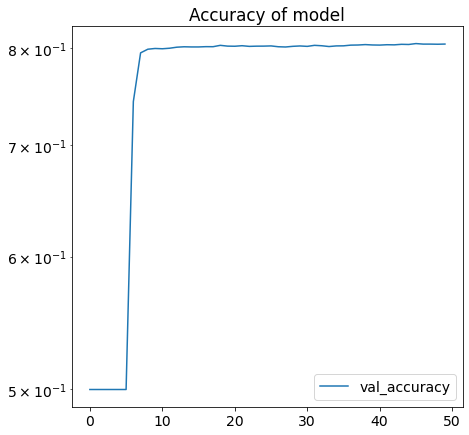

In [109]:
#plot val accuracy and loss
plt.yscale('log')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.title('Accuracy of model')
plt.show()

Text(0.5, 1.0, 'loss of model')

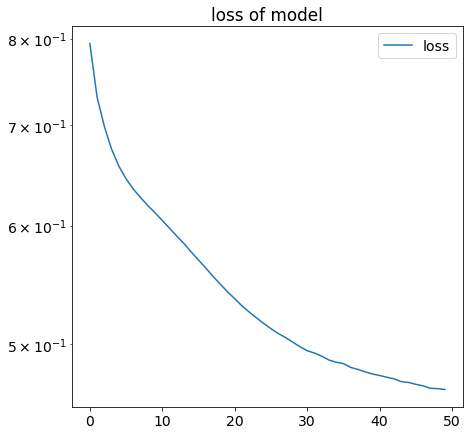

In [110]:
plt.yscale('log')
plt.plot(history.history['loss'],label='loss')
plt.legend()
plt.title('loss of model')

Accuracy and loss are good metrics here so I chose this model to be my optimal one. It has 8 inputs, 50 nodes and 4 dense layers.

In [111]:
from tensorflow . keras . callbacks import EarlyStopping , ModelCheckpoint
callbacks_ = [
# if we don ’t have an increase of the accuracy for 10 epochs , terminate training .
EarlyStopping ( verbose = True , patience =10 , monitor ='val_accuracy') ,
# Always make sure that we ’re saving the model weights with the best accuracy .
ModelCheckpoint ('model.h5', monitor ='val_accuracy', verbose =0 , save_best_only = True , mode ='max')]
history = model1.fit( train_data_dropped1 , train_target1 , batch_size = batchSize , epochs = N_epochs , \
verbose =1, validation_data =(test_data_dropped1, test_target1), callbacks = callbacks_)

Epoch 1/50
103/103 [==============================] - 0s 3ms/step - loss: 0.4650 - accuracy: 0.8008 - val_loss: 0.4602 - val_accuracy: 0.8044
Epoch 2/50
103/103 [==============================] - 0s 2ms/step - loss: 0.4646 - accuracy: 0.8012 - val_loss: 0.4592 - val_accuracy: 0.8045
Epoch 3/50
103/103 [==============================] - 0s 2ms/step - loss: 0.4630 - accuracy: 0.8012 - val_loss: 0.4580 - val_accuracy: 0.8044
Epoch 4/50
103/103 [==============================] - 0s 2ms/step - loss: 0.4628 - accuracy: 0.8015 - val_loss: 0.4577 - val_accuracy: 0.8054
Epoch 5/50
103/103 [==============================] - 0s 2ms/step - loss: 0.4619 - accuracy: 0.8014 - val_loss: 0.4563 - val_accuracy: 0.8055
Epoch 6/50
103/103 [==============================] - 0s 2ms/step - loss: 0.4601 - accuracy: 0.8020 - val_loss: 0.4550 - val_accuracy: 0.8052
Epoch 7/50
103/103 [==============================] - 0s 2ms/step - loss: 0.4590 - accuracy: 0.8014 - val_loss: 0.4534 - val_accuracy: 0.8050
Epoch 

Early stopping metric says 50 epochs are not needed and optimal accuracy is reached at epoch 32.

In [112]:
#get predictions from model
pred1 = model1.predict(test_data_dropped1)

In [113]:
#Reject events that have a predicted probability for the isSignal target feature less than 50%. 
predicted = []
for i in range(len(pred1)):
    if np.array(pred1)[i]>=0.5:
        predicted.append(1)
    else:
        predicted.append(0)

In [114]:
len(predicted)
#predicted

21992

In [115]:
from sklearn.metrics import confusion_matrix
#get confusion matrix for predicted and test data
cf_matrix = confusion_matrix(test_target1,predicted, labels=None, sample_weight=None, normalize='true')

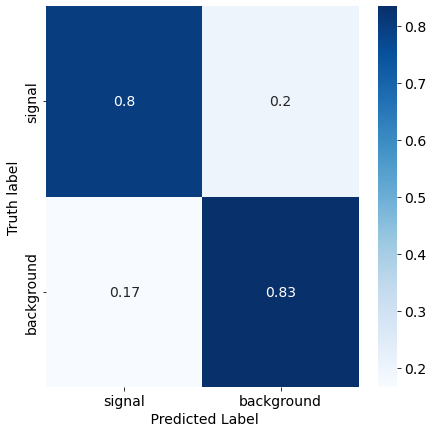

In [116]:
sns.heatmap(cf_matrix, annot=True, cmap='Blues',xticklabels=['signal','background'], yticklabels=['signal','background'])
plt.xlabel(" Predicted Label",fontsize=14)
plt.ylabel("Truth label",fontsize=14)
plt.show()

This confusion matrix shows that the model is 83% accurate at identifying background at 80% accurate at identifiying signal. This can be made better so I try using uncut data too.

In [117]:
#transform not fit_transform as fit will be different for whole data set
transformed_data1 = sc.transform ( training_dropped1 )
#check it is same length as original 50:50 data
len(transformed_data1)

73304

In [118]:
# Run the prediction of the model on the full (signal plus background) cut dataset
predicted_cut = model1.predict( transformed_data1 )

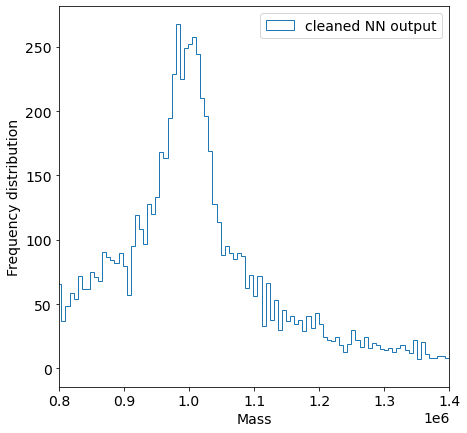

In [232]:
#Reject events that have a predicted probability for the isSignal target feature less than 50%.
make_array = 0.5*np.ones_like(predicted_cut)
truth_array = predicted_cut > make_array
#add predicted column to original data set (that has all columns)
training1['predicted'] = truth_array
#convert true/false to 0 and 1s and only keep 1s (i.e. keep what the NN has classified as signal and discard the rest)
#make new neural net data frame
NN_df1 = training1[pd.to_numeric(training1.predicted, errors='coerce') == 1]

#Plot the “cleaned” reco zv mass mass spectrum
plt.hist(NN_df1['reco_zv_mass'],weights=NN_df1['FullEventWeight'],histtype='step', bins=500,label='cleaned NN output')
plt.xlim([0.8e6,1.4e6])
plt.xlabel('Mass')
plt.ylabel('Frequency distribution')
plt.legend()
plt.show()

Here is the out put from the neural network. As you can see, it has done an extremely good job of eliminiating background, and the signal is very clear. The worry with this algorithm however is that the neural net may select background events that look like signal and make them look like signal hence getting a very clear signal shape. However, it is very efficient at detecting true background and eliminating it. 

In [120]:
NN_df1

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight,predicted
21846,254583.62,99268.21,399300.06,-0.774490,0.936660,90874.27,353793.53,47828.926,1026118.90,1,0.052744,True
19620,350180.97,159561.83,334162.53,-1.162194,1.251110,86188.00,504487.40,23805.220,910055.30,1,0.090247,True
31715,348754.10,192831.61,370514.10,1.021710,1.474197,89768.85,539108.80,40248.832,1120310.20,1,0.072189,True
33042,315066.88,130093.11,523096.28,-0.374186,1.754502,88400.37,440329.50,14677.298,995658.70,1,0.071880,True
4346,246478.38,237433.31,437626.78,-0.112153,1.869592,90153.49,483750.16,11926.763,963191.20,1,0.073112,True
...,...,...,...,...,...,...,...,...,...,...,...,...
769,419430.84,109343.77,486639.12,-0.245969,1.275909,89301.37,523748.34,27008.516,1029075.94,1,0.065543,True
64820,189548.86,177281.72,505120.70,1.745927,1.415083,90665.51,366585.25,24116.686,1849934.90,0,0.793552,True
16023,190779.55,153074.45,450294.94,-0.036428,0.493601,84300.43,342645.78,31023.697,957188.94,1,0.141767,True
860,391848.56,142914.06,389799.75,-0.096921,1.082124,86453.25,528401.94,60021.938,1010594.30,1,0.067452,True


In [121]:
len(training1)

73304

In [122]:
len(NN_df1)

37989

In [123]:
len(sig_H_cut)

36652

These lengths tell us that the length of the neural net output is around half (37989) the length of the 50:50 mixture of test training data (73304) , and similar in length to the signal data (36652) suggesting it mostly has selected signal. However the NN may have classified background to be signal. We can check this with the checks below:

In [125]:
#checks where the boolean flag for 'isSignal' is 1, i.e. is a true signal event

len(NN_df1[NN_df1['isSignal']==1])

30572

In [126]:
#checks where the boolean flag for 'isSignal' is 0, i.e. is a background event

len(NN_df1[NN_df1['isSignal']==0])

7417

Here the neural net has correctly predicted 30,572 events to be signal, and has incorrectly selected 7417 background events that look like signal. In order for this to be a physical result I sum the weightings for the signal and background in the neural network:

In [124]:
np.sum(NN_df1.loc[NN_df1['isSignal']==1]['FullEventWeight'])/(np.sum(NN_df1.loc[NN_df1['isSignal']==1]['FullEventWeight'])+np.sum(NN_df1.loc[NN_df1['isSignal']==0]['FullEventWeight']))

0.3097034800620919

This gives the weighted percentage of signal out of neural net as 31%.

---

#### LOOKING AT NN PERFORMANCE FOR UNCUT DATA

In [235]:
#for uncut data
#get number of samples same length as signal
bkg_samples = sklearn.utils.shuffle(combined_bkg, random_state=42, n_samples=len(sig_H))
precut = pd.concat([sig_H, bkg_samples], ignore_index=True)

In [236]:
precut = sklearn.utils.shuffle(precut, random_state=42)
precut.reset_index(drop=True);
target = precut['isSignal']

precut_dropped = precut.copy()
#get rid of columns that we do not want to feed into classifier
precut_dropped = precut_dropped.drop(columns=['reco_zv_mass','FullEventWeight','isSignal'])

In [237]:
sc = preprocessing.StandardScaler ()
input_data2 = sc.fit_transform ( precut_dropped )
# train - test split of dataset 70:30
train_data_dropped2, test_data_dropped2, train_target2, test_target2 = model_selection.train_test_split (\
input_data2 , target , test_size =0.3 , random_state = 42 )
print ( train_data_dropped2.shape, train_target2.shape, test_data_dropped2.shape , test_target2.shape )

(70018, 8) (70018,) (30008, 8) (30008,)


In [238]:
#compile model
model2 = my_model(8, 50, 3)

In [239]:
#fit model
history = model2.fit(train_data_dropped2, train_target2, batch_size = batchSize, epochs = N_epochs, \
verbose =0, validation_data =( test_data_dropped2, test_target2 ))

In [240]:
#get predictions from model
pred2 = model2.predict(test_data_dropped2)

In [241]:
#Reject events that have a predicted probability for the isSignal target feature less than 50%. 
predicted2 = []
for i in range(len(pred2)):
    if np.array(pred2)[i]>=0.5:
        predicted2.append(1)
    else:
        predicted2.append(0)

In [242]:
cf_matrix = confusion_matrix(test_target2,predicted2, labels=None, sample_weight=None, normalize='true')

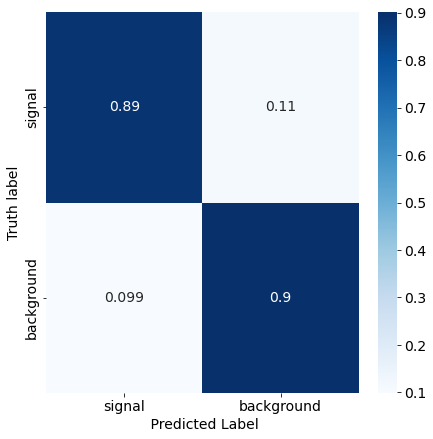

In [243]:
sns.heatmap(cf_matrix, annot=True, cmap='Blues',xticklabels=['signal','background'], yticklabels=['signal','background'])
plt.xlabel(" Predicted Label",fontsize=14)
plt.ylabel("Truth label",fontsize=14)
plt.show()

Here we can already see that the NN performs better when trained on uncut data. This is because it can now see outside the 0.8TeV-1.4TeV region, where there will be characteristic behaviours of the different background. Since the NN has more data to work with, it will be better at identifying what is background or not. It is 90% accurate at predicting background as background and 89% accurate as predicting signal as signal

In [244]:
#transform the uncut data
transformed_data2 = sc.transform ( precut_dropped )
len(transformed_data2)

100026

In [245]:
# Run the prediction of the model on the full (signal plus background) dataset with no cuts
predicted_uncut = model2.predict( transformed_data2 )

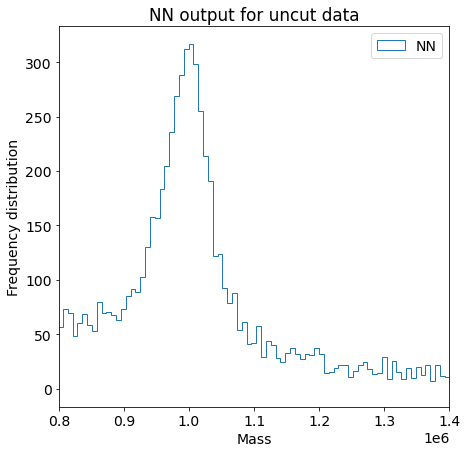

In [246]:
#Reject events that have a predicted probability for the isSignal target feature less than 50%.
make_array = 0.5*np.ones_like(predicted_uncut)
truth_array = predicted_uncut > make_array
#add predicted column to data set
precut['predicted'] = truth_array
#convert true/false to 0 and 1s and only keep 1s (i.e. keep what the NN has classified as signal and discard the rest)
NN_df2 = precut[pd.to_numeric(precut.predicted, errors='coerce') == 1]

#Plot the “cleaned” reco zv mass mass spectrum
plt.hist(NN_df2['reco_zv_mass'],weights=NN_df2['FullEventWeight'],histtype='step',bins=500,label='NN')
plt.legend()
plt.xlim([0.8e6,1.4e6])
plt.xlabel('Mass')
plt.ylabel('Frequency distribution')
plt.title('NN output for uncut data')
plt.legend()
plt.show()

Here we can see the output has less background than for the cut data, as expected, as the neural net behaves better. There is more distinction in the gaussian curve in the lower region between 0.8 and 0.9 TeV, where previously it was more linear. This shows that the NN has predicted less background as signal which we can check below:

In [247]:
#len dataframe from NN
len(NN_df2)

50834

In [248]:
#len precut data
len(precut)

100026

In [249]:
NN_df2

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight,predicted
39389,236095.83,223591.67,471153.53,-1.278958,1.428814,85647.080,451638.40,32944.560,954156.40,1,0.065435,True
32431,280150.56,232889.78,450749.06,-0.891372,0.625325,89382.484,506066.84,15525.514,976539.25,1,0.115353,True
49834,303353.16,170069.78,496729.30,-0.595946,0.711557,89189.390,473213.72,57355.280,986375.30,1,0.073636,True
27636,329526.28,87855.54,457259.66,-0.185459,1.773323,93891.240,417380.12,25484.664,989079.70,1,0.074324,True
48151,297546.16,184550.61,500127.62,0.247857,0.807997,90897.610,473819.66,21941.715,1013944.75,1,0.144182,True
...,...,...,...,...,...,...,...,...,...,...,...,...
44131,214662.92,201598.95,426325.72,-0.609577,0.830466,101626.484,407611.66,20689.574,1001113.30,1,0.071401,True
37194,412329.70,96441.67,308534.78,-0.592999,0.569407,90762.984,503003.44,20152.377,986120.00,1,0.073605,True
6265,390174.34,70919.03,436243.97,-0.072294,0.359615,108599.360,450300.88,38838.617,923796.94,1,0.071651,True
860,360028.78,182593.40,515074.75,0.442022,2.344393,81439.720,540881.30,19964.430,1091936.50,1,0.072139,True


In [250]:
NN_df2.loc[NN_df2['isSignal']==0].shape[0]

5727

In [251]:
NN_df2.loc[NN_df2['isSignal']==1].shape[0]

45107

In [252]:
#fraction of signal in neural network
NN_df2.loc[NN_df2['isSignal']==1].shape[0] / (NN_df2.loc[NN_df2['isSignal']==0].shape[0] + NN_df2.loc[NN_df2['isSignal']==1].shape[0])
#this is concurrent for the confusion matrix

0.8873391824369516

The NN with training on the uncut data predicted 5727 background events as signal, and correctly predicted 45,107 signal events as signal, giving 89% correctly predicted signal as shown in confusion matrix. Putting the weights in we get a weighted signal fraction below which is 46%, a better performance than the previous NN trained on cut data. Here we can see that training on the uncut data is much better, as the neural net can understand what happens in regions beyond the 0.8 and 1.4tev regions so it can understand the characteristics of the background.

In [145]:
#percentage of weighted signal
np.sum(NN_df2.loc[NN_df2['isSignal']==1]['FullEventWeight'])/(np.sum(NN_df2.loc[NN_df2['isSignal']==1]['FullEventWeight'])+np.sum(NN_df2.loc[NN_df2['isSignal']==0]['FullEventWeight']))

0.46079771754123205

We've changed the shape of the background in classifying it with the neural net. This means with real experimental data without the truth array, it would harder to tell if the signal is real, or if the NN has classified background to look like signal. In real life, we would assume there is something that can model the background e.g. a photon decay which is linear. For the H0 and H1 fits, I assume a linear background here.

## Repeat $\chi^2$ fits for H0 and H1 on the neural net dataset 

Repeat fits for the neural net outcome to different curves within region in the previous section, 0.8 to 1.4TeV.

In [253]:
#get centers and weighted sum and sum of weights squared for the neural net output
NN_cut_data = NN_df2.copy()
NN_cut_data = NN_cut_data.loc[(NN_cut_data['reco_zv_mass'] >= 0.8e6) & (NN_cut_data['reco_zv_mass'] <= 1.4e6)]
NN_heights,NN_bins = np.histogram(NN_cut_data['reco_zv_mass'],weights=NN_cut_data['FullEventWeight'], bins=100)
NN_heights2,NN_bins2 = np.histogram(NN_cut_data['reco_zv_mass'],weights=NN_cut_data['FullEventWeight']**2, bins=100)
NN_bin_centers = NN_bins[:-1] + np.diff(NN_bins)/2

In [254]:
from scipy.stats import norm

In [255]:
mu_NN, std_NN = norm.fit(NN_cut_data['reco_zv_mass'])

In [256]:
#define a composite function which is linear plus a gaussian signal
def composite_fit(data,mean,sigma,k,a,b):
    return ((a*data + b) + k*np.exp(-0.5*(data-mean)**2/(sigma**2)))

#curve fit the data to the composite function (the H1 hypothesis)
popt_NN,pcov_NN = curve_fit(composite_fit,NN_bin_centers,NN_heights,p0=[mu_NN, std_NN,250,-30,50])

In [257]:
popt_NN

array([ 9.95819947e+05,  3.43048959e+04,  2.01849555e+02, -8.69227565e-05,
        1.27770563e+02])

In [258]:
#get heights for given bin centers and parameters
y_NN_H0 = composite_fit(NN_bin_centers,*popt_NN)

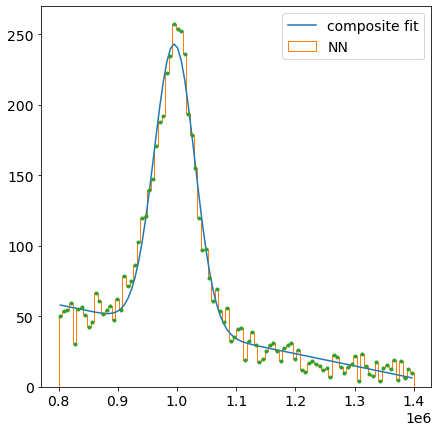

In [259]:
#plot neural net data against the curve fitted function for the composite function 
plt.plot(NN_bin_centers,y_NN_H0, label='composite fit')
plt.hist(NN_cut_data['reco_zv_mass'],weights=NN_cut_data['FullEventWeight'],histtype='step',bins=100,label='NN')
plt.plot(NN_bin_centers,NN_heights,'.')
plt.legend()
plt.show()

In [260]:
#define linear function for the background
def linear_fit(data,k,a,b):
    return (a*data + b)*k

In [261]:
#fit to background
popt_NN_lin,pcov_NN_lin = curve_fit(linear_fit,NN_bin_centers,NN_heights,p0=[250,-30,50])

In [262]:
popt_NN_lin

array([-2.43018078e-01,  7.71421032e-04, -1.09994536e+03])

In [263]:
#get heights from linear function
y_NN_H1 = linear_fit(NN_bin_centers,*popt_NN_lin)

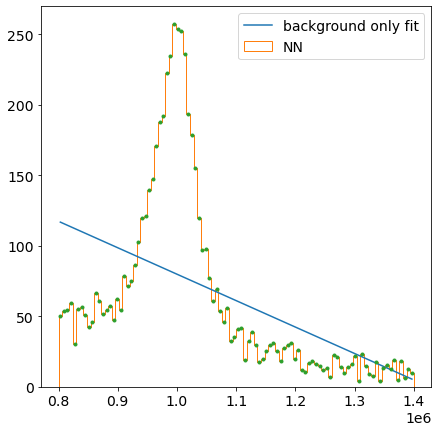

In [265]:
#plot neural net data and minimized linear background function
plt.plot(NN_bin_centers,y_NN_H1, label='background only fit')
plt.hist(NN_cut_data['reco_zv_mass'],weights=NN_cut_data['FullEventWeight'],histtype='step',bins=100,label='NN')
plt.plot(NN_bin_centers,NN_heights,'.')
plt.legend()
plt.show()

Here, as expected, the linear function is a terrible fit. This is because I am assuming linear background, and curve_fit aims to minimize the difference between the fit and the data points, hence the line is cut diagonally through the gaussian curve. Because the neural net has eliminated so much background, the background only hypothesis will have a really high chi squared value.

Repeat the two-fit procedure, assuming H1 and H0 hypotheses, and calculate the
statistical significance of the signal-like deviation. Is the result better or worse than
the one obtained in the previous Section?

In [266]:
#get chi squared values
def H0_chi2(params):
    """ background only hypothesis"""
    k, a, b = params
    y = linear_fit(NN_bin_centers, k, a, b)
    chi2 = np.sum(((NN_heights-y)**2)/NN_heights2)
    return chi2


def H1_chi2(params):
    """ signal+background hypothesis"""
    mu, sigma, k, a, b = params
    y = composite_fit(NN_bin_centers, mu, sigma, k, a, b)
    chi2 = np.sum(((NN_heights-y)**2)/NN_heights2)
    return chi2


In [267]:
H0_chi2(popt_NN_lin)

4777.915767004488

In [268]:
H1_chi2(popt_NN)

177.20754129517573

In [269]:
h0_NN = minimize(H0_chi2, x0=[*popt_NN_lin], method="powell")
h1_NN = minimize(H1_chi2, x0=[*popt_NN], method="powell")

In [270]:
h0_NN

   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-1.26853843e-02,  9.46995840e-06, -1.53969026e+00]])
     fun: 4522.153083404
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([-2.31237490e-01,  8.02035651e-04, -1.10609065e+03])

In [271]:
h1_NN

   direc: array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])
     fun: 159.79227641597174
 message: 'Optimization terminated successfully.'
    nfev: 195
     nit: 4
  status: 0
 success: True
       x: array([ 9.95468962e+05,  3.48066967e+04,  2.01705117e+02, -8.89652057e-05,
        1.27718712e+02])

In [275]:
h0_NN.fun, h1_NN.fun

(4522.153083404, 159.79227641597174)

The minimizer has minimized the H1 hypothesis to be 160, a relatively good fit given that it is on the order of the bin number, 100. The H0 hypothesis is, as expected, a really high chi squared value as the background only fit does not correspond at all to the data. This means that the p value, which relies on the difference between the two chi squared values, will be absolute zero. Whilst it was $10^{-11}$ before, for the kinematic cuts and a 4th order polynomial + gaussian fit, this value is even smaller (actually resolved to 0) because the chi2 value for the background hypothesis on the neural net data is so large. Since the NN eliminates so much background, we expect the p value to be 0 for this output. Because the data does not fit at all to the background only hypothesis, there is 0 probability of the signal observed being due to a random fluxuation in background.

In [272]:
#difference between the chi squared values for H0 and H1 hypotheses
D = h0_NN.fun - h1_NN.fun
#degrees of freedom (extra degree of freedom is the signal fraction in H1)
dof = 1
#get the p value difference
p_val_diff = chi2.sf(D,dof)

In [273]:
D

4362.360806988028

In [274]:
p_val_diff

0.0

## 4. Impact of training sample on classifier [10%]


- Design a new NN classifier, after incorporating reco zv mass somehow in the training: by explicitly making it one of the input features of the NN classifier

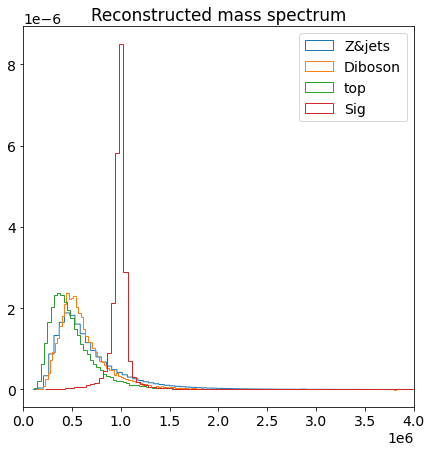

In [167]:
#plot zv mass reco spectrum for all backgrounds and signal
plt.hist(bkg_Zj['reco_zv_mass'],bins=1000, density=True, histtype='step',weights=bkg_Zj['FullEventWeight'], label='Z&jets')
plt.hist(bkg_Db['reco_zv_mass'],bins=500, density=True, histtype='step',weights=bkg_Db['FullEventWeight'], label='Diboson')
plt.hist(bkg_top['reco_zv_mass'],bins=100, density=True, histtype='step',weights=bkg_top['FullEventWeight'], label='top')
plt.hist(sig_H['reco_zv_mass'],bins=100, density=True, histtype='step',weights=sig_H['FullEventWeight'], label='Sig')
plt.xlim([0,0.4e7])
plt.legend()
plt.title('Reconstructed mass spectrum')
plt.show()

In [168]:
#for uncut data
#get number of samples same length as signal (50:50 mixture)
bkg_samples = sklearn.utils.shuffle(combined_bkg, random_state=42, n_samples=len(sig_H))
precut = pd.concat([sig_H, bkg_samples], ignore_index=True)

In [169]:
training3 = sklearn.utils.shuffle(precut, random_state=42)
training3.reset_index(drop=True);
target = training3['isSignal']

training_dropped3 = training3.copy()
#get rid of columns that we do not want to feed into classifier
#keep reco zv mass
training_dropped3 = training_dropped3.drop(columns=['FullEventWeight','isSignal'])

In [170]:
sc = preprocessing.StandardScaler ()
input_data3 = sc.fit_transform ( training_dropped3 )

# train - test split of dataset 70:30
train_data_dropped3, test_data_dropped3, train_target3, test_target3 = model_selection.train_test_split (\
input_data3 , target , test_size =0.3 , random_state = 42 )
print ( train_data_dropped3.shape , train_target3.shape , test_data_dropped3.shape , test_target3.shape )

(70018, 9) (70018,) (30008, 9) (30008,)


In [171]:
#compile model
model3 = my_model(9, 50, 3)

In [172]:
#fit model
history = model3.fit(train_data_dropped3, train_target3, batch_size = batchSize, epochs = N_epochs, \
verbose =0, validation_data =( test_data_dropped3, test_target3 ))

In [173]:
#get predictions from model
pred3 = model3.predict(test_data_dropped3)

In [174]:
#Reject events that have a predicted probability for the isSignal target feature less than 50%. 
predicted3 = []
for i in range(len(pred3)):
    if np.array(pred3)[i]>=0.5:
        predicted3.append(1)
    else:
        predicted3.append(0)

In [175]:
#get confusion matrix for NN with zv reco mass as an input
cf_matrix = confusion_matrix(test_target3,predicted3, labels=None, sample_weight=None, normalize='true')

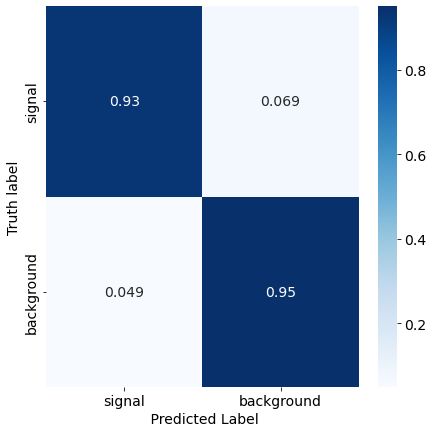

In [176]:
sns.heatmap(cf_matrix, annot=True, cmap='Blues',xticklabels=['signal','background'], yticklabels=['signal','background'])
plt.xlabel(" Predicted Label",fontsize=14)
plt.ylabel("Truth label",fontsize=14)
plt.show()

Here we can see that the NN performs even better with `zv_reco_mass` included as a variable. I suspect one reason for this is because on the `zv_reco_mass` spectrum shown above, backgrounds all have rather similar behaviours, their curves look the same, whereas signal is on the 1TeV peak, and this is the signature that we are looking for. The NN therefore must classify things even better as it has another input variable to train with, a variable which is a good indicator of what the signal actually looks like.

In [177]:
#tranform not fit transform as fit performed on subset used for training data will be different for the full data set
#data set

transformed_data3 = sc.transform ( training_dropped3 )
len(transformed_data3)

100026

In [178]:
#get predictions for full data set
predicted_with_mass = model3.predict( transformed_data3 )

C:\Users\betc\anaconda3\envs\daml\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


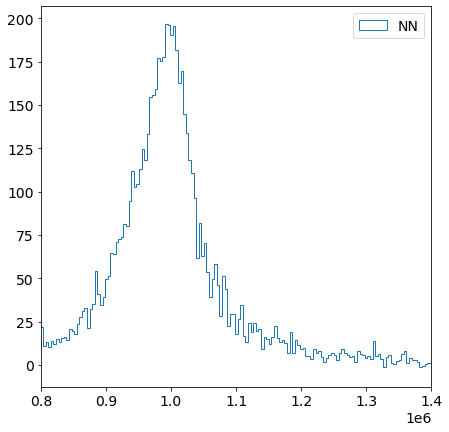

In [179]:
#Reject events that have a predicted probability for the isSignal target feature less than 50%.
make_array = 0.5*np.ones_like(predicted_with_mass)
truth_array = predicted_with_mass > make_array
#add predicted column to un dropped data set
training3['predicted'] = truth_array
#convert true/false to 0 and 1s and only keep 1s (i.e. keep what the NN has classified as signal and discard the rest)
NN_df3 = training3[pd.to_numeric(training3.predicted, errors='coerce') == 1]

#Plot the “cleaned” reco zv mass mass spectrum.
plt.hist(NN_df3['reco_zv_mass'],weights=NN_df3['FullEventWeight'],histtype='step',bins=500,label='NN')
plt.legend()
plt.xlim([0.8e6,1.4e6])
plt.show()

In [180]:
#fraction of signal in neural network
NN_df3.loc[NN_df3['isSignal']==1].shape[0] / (NN_df3.loc[NN_df3['isSignal']==0].shape[0] + NN_df3.loc[NN_df3['isSignal']==1].shape[0])
#this is concurrent for the confusion matrix

0.9323876883289904

In [181]:
#percentage of weighted signal
np.sum(NN_df3.loc[NN_df3['isSignal']==1]['FullEventWeight'])/(np.sum(NN_df3.loc[NN_df3['isSignal']==1]['FullEventWeight'])+np.sum(NN_df3.loc[NN_df3['isSignal']==0]['FullEventWeight']))

0.604196883629987

Clearly, the ML classifier is much better when reco mass is included as one of the input variables. It predicts 93% of signal to be signal and the weighted signal is 60%, compared to the other NN which gave weighted signals of 31% and 46% for the cut and uncut data respectively. The ML is better after incorporating variable reco zv mass because it has less chance of predicting background events as signal as reco zv mass is a characteristic shape for the backgrounds and signal respectively. Further more,it makes it better as it is an extra free parameter/input variable. And it also acts like the target parameter, since `isSignal` is mainly determined by `reco_zv_mass`. Since it gives more information, there will be better fitting, and it is independent information that can't be reconstructed from the other variables, sincde it introduces a better fit and better accuracy.


This output data would also give a p value of 0 when fit to H0 and H1 hypotheses, as the signal is so clear and there would not be a sufficient way to model the background without having a very high chi squared value. The signal is very clear and the NN are successful at eliminating background. The only concern would be for real experiments where there is no truth value, as you want to be careful not to let the NN select background data that looks like a signal, and shape the data in such a way. Therefore it is good to do both hypothesis testing, one with optimized selection cuts based on real physics (i.e. what shape to the background decays take, from knowledge of particle physics), and one with the neural network, or other machine learning methods.

---

Thanks for reading!